In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Spatial implementation suffers in time on a GPU due to a TF bug, therefore consider disabling it
# Also, due to a TF bug there seems to be a memory leakage between LMMNN and other methods when run together,
# and those other methods suffer in performance. Consider running LMMNNN separately.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.layers import NLL
from lmmnn.callbacks import EarlyStoppingWithSigmasConvergence
from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_lmm, reg_nn_embed

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer, Input, Dropout, Embedding, Reshape, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.backend as K

import tensorflow as tf

In [4]:
# Note: pa_final.csv is the result of an ETL process described in Pierce et. al. (2020), see our paper
# after downloading the UKB relevant data.
ukb = pd.read_csv('../data/pa_final2.csv')
ukb.drop(['center', 'job', 'job_orig', 'center_orig', 'north', 'east'], axis=1, inplace=True)

In [5]:
ukb.head()

gender   enmo  heavy_work  walking_work  sedentary_work      mvpa  \
0       0  27.17    0.000000      0.000000        5.957686  4.824879   
1       0  29.72    4.110874      5.198497        0.000000  5.900680   
2       0  35.82    0.000000      0.000000        0.000000  3.828641   
3       1  25.53    0.000000      0.000000        0.000000  4.156648   
4       0  23.97    3.780938      4.864232        0.000000  3.986335   

   walking_pleasure  strenuous_sport  other_act  light_diy  ...  getting_walk  \
0          2.983153              0.0   2.460809   0.000000  ...             0   
1          1.613003              0.0   2.837406   0.000000  ...             0   
2          3.398814              0.0   0.000000   2.837406  ...             0   
3          3.999510              0.0   2.005334   0.589769  ...             0   
4          2.339399              0.0   0.000000   1.438480  ...             0   

   commuting_cycle  commuting_other  commuting_transport  commuting_walk  \
0                0                0                    0               1   
1                0                0                    0               0   
2                0                1                    0               0   
3                0                1                    0               0   
4                0                0                    0               1   

   sleep      bmi  north_range  east_range  location  
0      7  23.4959    -7.661017    5.148248         0  
1      7  24.1797    -7.661017    5.148248         0  
2      7  21.4786    -7.661017    5.148248         0  
3      7  29.3724    -7.661017    5.148248         0  
4      8  23.3203    -7.661017    5.148248         0  

[5 rows x 26 columns]

In [6]:
ukb = ukb[ukb['enmo'] < 80]
ukb.index = range(ukb.shape[0])

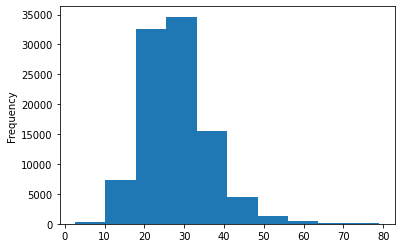

In [7]:
ukb['enmo'].plot(kind='hist')
plt.show()

In [8]:
ukb.groupby(['east_range', 'north_range']).size().shape[0]

11458

In [9]:
len(ukb['location'].unique())

11458

In [10]:
ukb['location'].max()

11457

In [11]:
n_cats = len(ukb['location'].unique())

In [12]:
ukb.shape

(96629, 26)

In [13]:
mode = 'spatial'
n_sig2bs = 2
est_cors = []

In [14]:
coords = ukb.groupby(['location','east_range', 'north_range']).size().index.to_frame().values

In [15]:
coords[:5]

array([[ 0.        ,  5.14824798, -7.66101695],
       [ 1.        ,  0.88948787,  4.30508475],
       [ 2.        , -0.35040431,  6.06779661],
       [ 3.        ,  1.26684636, -6.16949153],
       [ 4.        ,  0.7277628 , -2.06779661]])

In [16]:
dist_matrix = squareform(pdist(coords[:,1:])) ** 2

In [17]:
dist_matrix.shape

(11458, 11458)

In [18]:
ukb.rename(columns={'east_range': 'D1', 'north_range': 'D2', 'location': 'z0'}, inplace=True)

In [19]:
ukb.columns

Index(['gender', 'enmo', 'heavy_work', 'walking_work', 'sedentary_work',
       'mvpa', 'walking_pleasure', 'strenuous_sport', 'other_act', 'light_diy',
       'heavy_diy', 'tv', 'computer', 'getting_cycle', 'getting_other',
       'getting_transport', 'getting_walk', 'commuting_cycle',
       'commuting_other', 'commuting_transport', 'commuting_walk', 'sleep',
       'bmi', 'D2', 'D1', 'z0'],
      dtype='object')

In [20]:
def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=30, epochs=100, patience=10, reg_type='ohe', deep=False, verbose=False):
    start = time.time()
    if reg_type == 'ohe':
        y_pred, sigmas, _, n_epochs = reg_nn_ohe_or_ignore(X_train, X_test, y_train, y_test, [n_cats], x_cols, batch, epochs, patience, mode, n_sig2bs, est_cors, deep, verbose)
    elif reg_type == 'lmm':
        y_pred, sigmas, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, [n_cats], x_cols, batch, epochs, patience, mode, n_sig2bs, est_cors, dist_matrix, deep, verbose)
    elif reg_type == 'ignore':
        y_pred, sigmas, _, n_epochs = reg_nn_ohe_or_ignore(X_train, X_test, y_train, y_test, [n_cats], x_cols, batch, epochs, patience, mode, n_sig2bs, est_cors, deep, verbose, ignore_RE=True)
    elif reg_type == 'embed':
        y_pred, sigmas, _, n_epochs = reg_nn_embed(X_train, X_test, y_train, y_test, [n_cats], x_cols, batch, epochs, patience, mode, n_sig2bs, est_cors, deep, verbose)
#     elif reg_type == 'menet':
#         y_pred, sigmas, n_epochs = reg_nn_menet(X_train, X_test, y_train, y_test, n_cats, batch, epochs, patience, deep)
    else:
      raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    mse = np.mean((y_pred - y_test)**2)
    return mse, sigmas, n_epochs, end - start

In [21]:
res = pd.DataFrame(columns=['experiment', 'exp_type', 'deep', 'mse', 'sigma_e_est', 'sigma_b0_est', 'sigma_b1_est', 'n_epoch', 'time'])
counter = 0

def iterate_reg_types(X_train, X_test, y_train, y_test, deep, verbose):
    global counter
    mse_lmm, sigmas, n_epochs_lmm, time_lmm = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', deep=deep, verbose=verbose)
    print(' finished lmm deep=%s, mse: %.2f' % (deep, mse_lmm))
    gc.collect()
    mse_ohe, _, n_epochs_ohe, time_ohe = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='ohe', deep=deep, verbose=verbose)
    print(' finished ohe deep=%s, mse: %.2f' % (deep, mse_ohe))
    gc.collect()
    mse_ig, _, n_epochs_ig, time_ig = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='ignore', deep=deep, verbose=verbose)
    print(' finished ignore deep=%s, mse: %.2f' % (deep, mse_ig))
    gc.collect()
    mse_em, _, n_epochs_em, time_em = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='embed', deep=deep, verbose=verbose)
    print(' finished embed deep=%s, mse: %.2f' % (deep, mse_em))
    gc.collect()
    # mse_me, sigmas_me, n_epochs_me, time_me = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='menet', deep=deep, verbose=verbose)
    # print(' finished menet deep=%s, mse: %.2f' % (deep, mse_me))
    res.loc[counter + 0] = [i, 'ohe', deep, mse_ohe, np.nan, np.nan, np.nan, n_epochs_ohe, time_ohe]
    res.loc[counter + 1] = [i, 'lmm', deep, mse_lmm, sigmas[0], sigmas[1][0], sigmas[1][1], n_epochs_lmm, time_lmm]
    res.loc[counter + 2] = [i, 'ignore', deep, mse_ig, np.nan, np.nan, np.nan, n_epochs_ig, time_ig]
    res.loc[counter + 3] = [i, 'embed', deep, mse_em, np.nan, np.nan, np.nan, n_epochs_em, time_em]
#     res.loc[counter + 4] = [i, 'menet', deep, mse_me, sigmas_me[0], np.nan, n_epochs_me, time_me]
    counter += 4

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X, y = ukb.drop('enmo', axis=1), ukb['enmo']
x_cols = [col for col in X.columns if col != 'z0']
print(x_cols)

['gender', 'heavy_work', 'walking_work', 'sedentary_work', 'mvpa', 'walking_pleasure', 'strenuous_sport', 'other_act', 'light_diy', 'heavy_diy', 'tv', 'computer', 'getting_cycle', 'getting_other', 'getting_transport', 'getting_walk', 'commuting_cycle', 'commuting_other', 'commuting_transport', 'commuting_walk', 'sleep', 'bmi', 'D2', 'D1']


In [23]:
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print('iteration %d' % i)
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y[train_index], y[test_index]
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(X_train.shape[0])
    y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(X_test.shape[0])
    y_train = pd.Series(y_train, index=X_train.index)
    y_test = pd.Series(y_test, index=X_test.index)
    iterate_reg_types(X_train, X_test, y_train, y_test, deep=True, verbose=True)

In [24]:
res

In [ ]:
res.to_csv('../results/res_ukb_pa_spatial.csv')